# Hyperparameter Search Strategy
We will be conducting a series of experiments to determine the best hyperparameter combinations while keeping certain model parameters constant. Each experiment focuses on one aspect of the model's design. The best model from each experiment is selected and improved in the next experiment. Finally we will do a couple of advanced tunings such as:
* Increasing dataset size by agumenting the training images with the **ImageDataGenerator**
* Adding a learning rate decay to the optimization algorithm with the **LearningRateScheduler**
* Adding a **Batch Normalization** layer after every convolutional layer
* Tweaking the overall model structure by replacing certain layer combinations with others

With this iterative approach we avoid having to explore the many thousands of combinations that arise if we were to conduct tests for each parameter.

We will be using the following model naming conventions:
1. **24C5** means a convolutional layer with 24 nodes with a 5x5 kernel and stride 1
2. **24C5S2** means a convolutional layer with 24 nodes with a 5x5 kernel and stride 3
3. **24C5n** same as *1* plus batch normalization layer
4. **P2** means a max pooling layer using a 2x2 filter and stride 2
5. **256** means a dense layer with 256 nodes
6. **256n** same as *5* plus batch normalization layer
7. **D0.4** means a dropout layer with 40% dropout rate
8. **E4** experiment 4

## The Experiments:
1. Number of convolutional layers
2. Number of nodes in each convolutional layer
3. Number of nodes in the fully connected (dense) layer
4. Dropout layer and dropout rate
5. Advanced Tunings

## Epochs, Samples and Validation Set
1. epochs=15, samples=70k, validation=15%
2. epochs=15, samples=70k, validation=15%
3. epochs=15, samples=70k, validation=15%
4. epochs=30, samples=70k, validation=15%
5. epochs=35, training=200k, validation=10k, testing=10k

## Where are the experiments?
In this notebook you will not be seeing the codes. You can find the codes for each experiment in the **tut_03_experiments.py**. The reasons why I have decided to not show the codes in the notebook are:
1. It would make this notebook very long
2. You will not be seeing anything new with regards to TensorFlow and Keras classes
3. Some of the models have a long training time if you don't have a GPU so you are not advised to run the code yourself

Experiments 1, 2, 3 and 4 are in the **`MNISTInitialExperiments`** class of the **tut_03_experiments.py** and the 5th experiment is in the **`MNISTAdvancedExperiment`** class. I have created 2 classes as the first 4 experiments combine all of the MNIST samples (train and test) into one dataset which is then passed to the models with a validation set ratio. The last experiment's traning samples uses only the MNIST training samples by spliting them into training and a validation set and augmenting the training set. You can find the logs in the **data/logs** folder of this repository (so `tensorboard --logdir=data/logs`), the trained models in the **data/models** folder and the downloaded CSVs of the metrics from TensorBoard are in the **data/csv** folder.

**However**, you will be finding how the data agumentation is done and how we will be scheduling the learning rate of the of advanced models in this notebook as that you have not seen before. This will be the last part of this tutorial. We will now show and discuss the results of each experiment.

In [24]:
# Helper functions

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

colours = list(mcolors.TABLEAU_COLORS)
%matplotlib inline

def get_results(experiment):
    val_acc = []
    val_loss = []
    
    for _, _, files in os.walk('data/csv'):
        files.sort()
        for name in files:
            temp_1 = name.replace(f'run-{experiment} ', '')
            if temp_1 != name:
                data = pd.read_csv(f'data/csv/{name}')['Value']
                data.index = range(1, len(data) + 1)
                if name.find('val_acc') > -1:
                    name =  temp_1.replace('-tag-epoch_val_acc.csv', '')
                    name = name[:name.find('@')]
                    data.name = name
                    val_acc.append(data)
                elif name.find('val_loss') > -1:
                    name =  temp_1.replace('-tag-epoch_val_loss.csv', '')
                    name = name[:name.find('@')]
                    data.name = name
                    val_loss.append(data)
    
    val_acc = pd.concat(val_acc, axis=1)
    val_loss = pd.concat(val_loss, axis=1)
    return val_acc, val_loss

def func_exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

def plot_results(val_acc, val_loss, alpha=None, acc_min=None, loss_max=None, acc_smoothing='exp'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 5], gridspec_kw={'width_ratios': [1, 1]})
    x = val_acc.index

    for i, metric in enumerate([val_acc, val_loss]):
        values = metric.values.ravel()
        values = values[~np.isnan(values)]  # Removing nans safely
        y_lims = [np.floor(values.min() * 1000) / 1000,
                  np.ceil(values.max() * 1000) / 1000]
        if i == 0 and acc_min != None:
            y_lims[0] = acc_min
        if i == 1 and loss_max != None:
            y_lims[1] = loss_max
        
        for j, col in enumerate(metric.columns):
            
            # Filtering out NANs
            original = metric[col].dropna()
            x_range = original.index
        
            # Smoothing
            if i == 0 and acc_smoothing == 'exp':
                popt, _ = curve_fit(func_exponential, x_range, original)
                smoothed = func_exponential(x_range, *popt)
            else:
                if alpha == None:
                    alpha = 0.1
                smoothed = original.ewm(alpha=alpha).mean().values
            original = original.values
            
            # Plotting
            ax[i].plot(x_range, smoothed, color=colours[j], alpha=1.0, ls='-', label=col)
            ax[i].plot(x_range, original, color=colours[j], alpha=0.3, ls='-')
        
        if i == 0:
            ax[i].set_title('Validation Accuracy')
        elif i == 1:
            ax[i].set_title('Validation Loss')
            ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                         prop={'size': 8})
        
        ax[i].set_xticks(np.arange(1, x[-1] + 1, 2))
        ax[i].set_xlim([x[0], x[-1]])
        ax[i].set_ylim(y_lims)
        ax[i].grid(True)
        # ax[i].legend(prop={'size': 8})
    
    ax[1].invert_yaxis()
    plt.show()

def printClassDistribution(y, title, top=False, end='\n'):
    classes, counts = np.unique(y, axis=0, return_counts=True)
    counts = counts * 100 / y.shape[0]
    for i, label in enumerate(classes):
        if i == 0:
            t = '{: 5}'.format(label)
            b = '{:5.2f}'.format(counts[i])
        else:
            t = t + '|{: 5}'.format(label)
            b = b + '|{:5.2f}'.format(counts[i])

    if top:
        print('{}|{:>7}\n{}|{: 7} {}'.format(t, 'TOTAL', b, y.shape[0], title), end=end)
    else:
        print('{}|{: 7} {}'.format(b, y.shape[0], title), end=end)

# 1. Number of Convolution Layers
* **1 Layer**: \[24C5-P2\] - 256 - 10
* **2 Layers**: \[24C5-P2\] - \[48C5-P2\] - 256 - 10
* **3 Layers**: \[24C5-P2\] - \[48C5-P2\] - \[64C5-P2\] - 256 - 10  

Number of nodes is being increased in each layer as that is a standard design pattern in CNNs. More than 3 layers with a kernel size of 5 will make the passed image too small.

### Results:

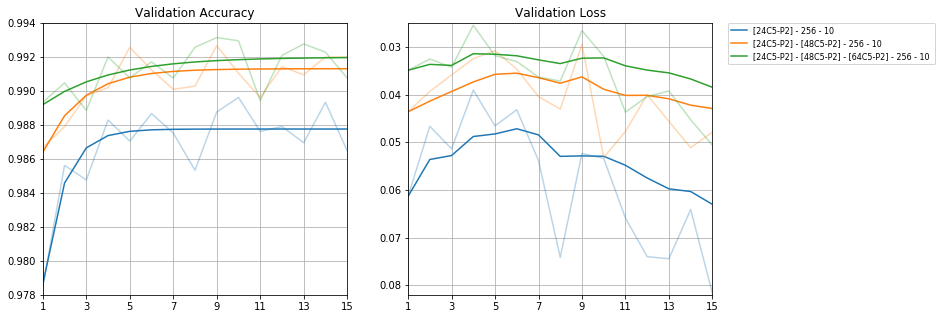

In [2]:
# Experiment 1
val_acc_1, val_loss_1 = get_results('E1')
plot_results(val_acc_1, val_loss_1)

### Discussion:
When trend lines are considered it is clear that the 3 layered model is better however it can also be see that the 2 layered model is very close in performance for both validation accuracy and validation loss. Not that much bang for buck if we adopt the 3 layered model so the 2 layered model will be carried forward into the other experiments 

# 2. Number of Nodes in each Convolutional Layer
* **8 and 16**: \[8C5-P2\] - \[16C5-P2\] - 256 - 10
* **16 and 32**: \[16C5-P2\] - \[32C5-P2\] - 256 - 10
* **24 and 48**: \[24C5-P2\] - \[48C5-P2\] - 256 - 10
* **32 and 64**: \[32C5-P2\] - \[64C5-P2\] - 256 - 10 
* **40 and 80**: \[40C5-P2\] - \[80C5-P2\] - 256 - 10
* **48 and 96**: \[48C5-P2\] - \[96C5-P2\] - 256 - 10

### Results:

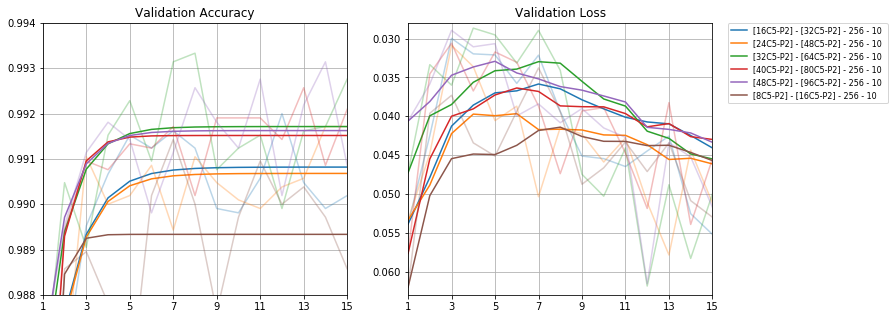

In [3]:
# Experiment 2
val_acc_2, val_loss_2 = get_results('E2')
plot_results(val_acc_2, val_loss_2, acc_min=0.988)

### Discussion:
32 and 64 is doing even better models that have more nodes in each convolutional layer when it comes to validation accuracy and has a much lower minimum validation loss wehn compared to all the other models.

# 3. Number of Nodes in the Fully Connected Layer
* **0**: \[32C5-P2\] - \[64C5-P2\] - X - 10 (no fully connected layer)
* **32**: \[32C5-P2\] - \[64C5-P2\] - 32 - 10
* **64**: \[32C5-P2\] - \[64C5-P2\] - 64 - 10
* **128**: \[32C5-P2\] - \[64C5-P2\] - 128 - 10
* **512**: \[32C5-P2\] - \[64C5-P2\] - 512 - 10
* **1024**: \[32C5-P2\] - \[64C5-P2\] - 1024 - 10

### Results:

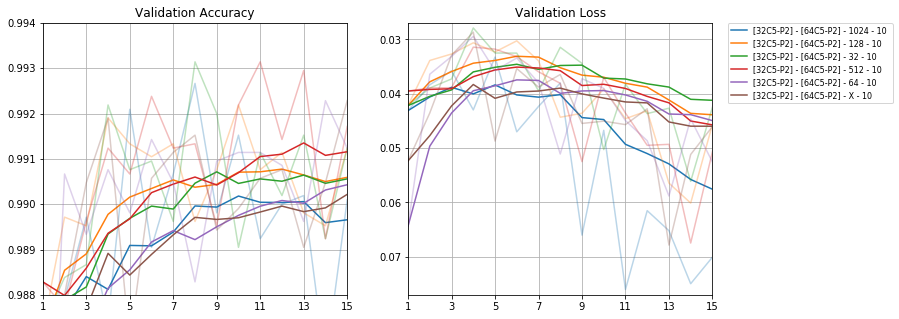

In [4]:
# Experiment 3
val_acc_3, val_loss_3 = get_results('E3')
plot_results(val_acc_3, val_loss_3, acc_smoothing='exp_weighted_mean', acc_min=0.988)

### Discussion
The choice here is not so clear cut. 512 is doing better with validation accuracy but not with validation loss. It is also the most computational intensive option so no... The next two candidates are 32 and 128. Keeping in mind that we should be including dropout layers (our next experiment) the logical conclusion should be 128.

# 4. Dropout Layer and Dropout Rate
* **0%**: \[32C5-P2\] - D0.0 - \[64C5-P2\] - D0.0 - 128 - D0.0 - 10
* **10%**: \[32C5-P2\] - D0.1 - \[64C5-P2\] - D0.1 - 128 - D0.1 - 10
* **20%**: \[32C5-P2\] - D0.2 - \[64C5-P2\] - D0.2 - 128 - D0.2 - 10
* **30%**: \[32C5-P2\] - D0.3 - \[64C5-P2\] - D0.3 - 128 - D0.3 - 10
* **40%**: \[32C5-P2\] - D0.4 - \[64C5-P2\] - D0.4 - 128 - D0.4 - 10
* **50%**: \[32C5-P2\] - D0.5 - \[64C5-P2\] - D0.5 - 128 - D0.5 - 10
* **60%**: \[32C5-P2\] - D0.6 - \[64C5-P2\] - D0.6 - 128 - D0.6 - 10
* **70%**: \[32C5-P2\] - D0.7 - \[64C5-P2\] - D0.7 - 128 - D0.7 - 10

### Results:

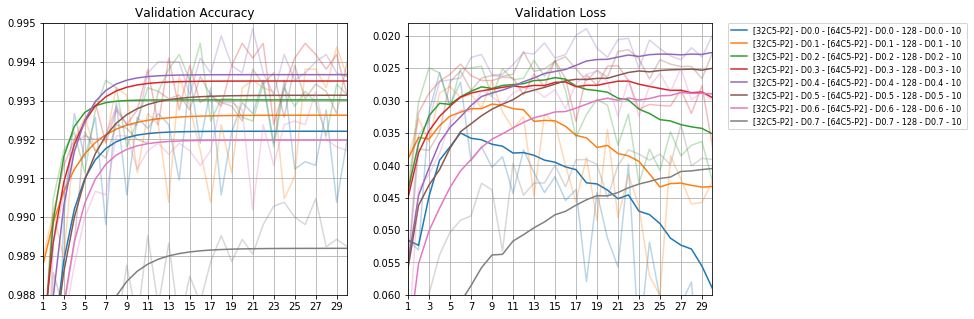

In [5]:
# Experiment 4
val_acc_4, val_loss_4 = get_results('E4')
plot_results(val_acc_4, val_loss_4, acc_min=0.988, loss_max=0.06)

### Discussion
We can clearly see the benefits of adding a dropout layer in our graphs above. The model's with the lowest 3 dropout rates (0%, 10% and 20%) all have their validation losses peaking and then increasing implying that the model's are not generalizing well. The validation loss trends can also be seen to become more stable as we increase the dropout rate. The only exception to this is 70% which means that there clearly is a maximum limit to the drop out rate when it comes to improving model performance metrics. The clear choice here is 40%: Not only does it have the best validation accuracy that we have seen so far but also the best validation loss we have seen so far. Its validation loss is still trending positively as well at the last epoch which suggests the model has not quiet overtrained yet.

# 5. Advanced Tunings
## 5.1 Inducing Learning Rate Decay
The learning rate is an important model design parameter as it effects the chances of the optimizer arriving at the local/global minimium therefore it is desirable to have a decay in learning rate towards later stages of the training. There are numerous ways of doing so and one of the most commonly practiced is to set the leanring rate constant up to a certain epoch and setting it to decay exponentially with the epoch thereafter.

If we take a look at all the validation accruacies from experiment 1 to 4, it can be seen that majority of the models are flattening out at around the 10th epoch. This will be our threshold up to each the learning will be kept at its maximum constant value.

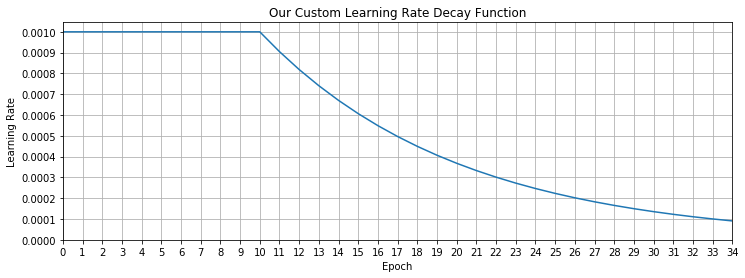

In [6]:
# Example code showing how to set up learning rate decay
from tensorflow.keras.callbacks import LearningRateScheduler

def learning_rate_decay_func(epoch):  # This is the sample function used for experiment 5 models
    if epoch < 10:
        return 0.001  # Default learning rate
    else:
        return 0.001 * np.exp(0.1 * (10 - epoch))  # Exponential decay after 10th epoch

# Plotting learning rate decay of the function
learning_rate = [learning_rate_decay_func(epoch) for epoch in range(35)]
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(range(35), learning_rate)
ax.set_xlim([0, 34])
ax.set_xticks(range(35))
ax.set_yticks(np.arange(0, 0.0011, 0.0001))
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.title('Our Custom Learning Rate Decay Function')
plt.grid(True)
plt.show()
    
# Learning rate scheduler
annealer = LearningRateScheduler(learning_rate_decay_func)

# Pass the annealer to the fit method of the model like so:
# model.fit(x, y, epochs=35, callbacks=[tensorboard, annealer])

## 5.2 Larger Training Set: Image Data Agumentation
In this section we will show how the number of training samples have been increased  to 200k from 50k original samples via image agumentations and we will also show that the agumented image generator never generates a duplicate and maintains the class distribution. At the end of this section you will also find a smaller example showing what the agumented images look like.

In [31]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.logging.set_verbosity(tf.logging.ERROR)

# Importing the dataste
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(x_train).reshape((-1, 28, 28, 1)) / 255.0
x_test = np.array(x_test).reshape((-1, 28, 28, 1)) / 255.0

# Original class distributions
print_class_distribution(y_test, 'Testing', top=True)
print_class_distribution(y_train, 'Training [original]')

# Saving 10k samples as validation set 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000)
print_class_distribution(y_val, 'Validation')

# Configuring the image agumentor
agumentor = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.10,
                               width_shift_range=0.1,
                               height_shift_range=0.1)

# Configuring the agumentor to generate 50k agumented samples at a time
samples_per_loop = x_train.shape[0]
generator = agumentor.flow(x_train, y_train, batch_size=samples_per_loop)

# Adding the original training samples to the new agumented training set
target_size = 200000
x_train_agu = x_train
y_train_agu = y_train
print_class_distribution(y_train_agu, 'Training [pre agumentation]')

# Generator 50k samples at a time
for x_agumented_batch, y_agumented_batch in generator:
    
    # Adding new agumented images
    x_train_agu = np.concatenate((x_train_agu, x_agumented_batch))
    y_train_agu = np.concatenate((y_train_agu, y_agumented_batch))
    
    # Getting number of duplicates
    dup = len(x_train_agu) - len(np.unique(x_train_agu, axis=0))
    
    # Class distribution: training set progress
    title = f'Training [adding] {dup} duplicates'
    print_class_distribution(y_train_agu, title, end='\r')
    
    # Breaking the loop once target size is reached
    if y_train_agu.shape[0] >= target_size:
        break
print_class_distribution(y_train_agu, f'Training [done] {dup} duplicates  ')

    0|    1|    2|    3|    4|    5|    6|    7|    8|    9|  TOTAL
 9.80|11.35|10.32|10.10| 9.82| 8.92| 9.58|10.28| 9.74|10.09|  10000 Testing
 9.87|11.24| 9.93|10.22| 9.74| 9.04| 9.86|10.44| 9.75| 9.91|  60000 Training [original]
10.27|11.28| 9.77|10.25| 9.53| 8.89| 9.64|10.71| 9.78| 9.88|  10000 Validation
 9.79|11.23| 9.96|10.21| 9.78| 9.06| 9.91|10.39| 9.75| 9.92|  50000 Training [pre agumentation]
 9.79|11.23| 9.96|10.21| 9.78| 9.06| 9.91|10.39| 9.75| 9.92| 200000 Training [done] 0 duplicates  


### Showing some sample agumented images

 0 classes have at least 5 samples. Classes of new images: [0 1 2 3 4 5 6 7 8 9]
 0 classes have at least 5 samples. Classes of new images: [0 1 2 3 4 5 6 7 8 9]
 0 classes have at least 5 samples. Classes of new images: [0 1 2 3 4 5 6 7 8 9]
10 classes have at least 5 samples. Classes of new images: [0 1 2 3 4 5 6 7 8 9]


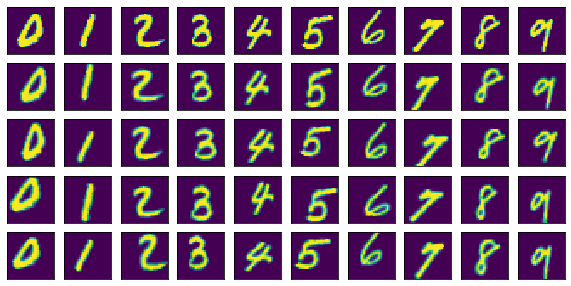

In [9]:
classes = range(10)
sample_ind = [np.where(y_train == class_label)[0][0] for class_label in classes]
x_sample = x_train[sample_ind]
y_sample = y_train[sample_ind]  # One instance of every class in sample set

# 1 row for original (first row) and remaining for sample augmented images
n_rows = 5  

# Configuring the generator for new sample set
generator = agumentor.flow(x_sample, y_sample, batch_size=len(x_sample))

# Generating augmented images for each class at least n_row times
for x, y in generator:
    x_sample = np.concatenate((x_sample, x))
    y_sample = np.concatenate((y_sample, y))
    score = 0
    for class_label in classes:
        if len(np.where(y_sample == class_label)[0]) >= n_rows:
            score = score + 1
    # Printing this so you can see how many time it has to generate to
    # meet the requirement
    y.sort()
    print('{:2g} classes have at least {} samples. Classes of new images: {}'.format(score, n_rows, y))
    if score == len(classes):
        break

# Showing images
fig, axs = plt.subplots(nrows=n_rows, ncols=len(classes), figsize=[10, n_rows])
for col, class_label in enumerate(classes):
    sample = np.where(y_sample == class_label)[0]
    for row in range(n_rows):
        axs[row, col].imshow(x_sample[sample[row], :, :, 0])
        axs[row, col].axes.get_xaxis().set_visible(False)
        axs[row, col].axes.get_yaxis().set_visible(False)
plt.show()

## 5.3 Adding Advanced Features
Convolution layers with kernel size of 5 can be replaced with 2 consecutive convolution layers with kernel size of 3 which is known to incease a model's nonlinear behaviour. Subsampling with Max pooling Layer can also be replaced with a convolution layer with a stride of 2 as it is said that the Max Pooling Layer's behaviour can be learned that way. We will try out both of these features in a new model to see how it fairs. With our model when both are trained with the new enlarged training set and our custom learning rate decay. We will also add a batch normalization layer after every
convolutional layer and the fully connected layer in the new model as it helps to increase the stability of a neural network. Let's list what we plan to change with the new model:
* Replace old model's **32C5** with **32C3-32C3**
* Replace old model's **P2** with **32C5S2**
* Add a batch normalization later after every convolutional layer and the dense layer: `model.add(BatchNormalization())`

Ideally we should be testing each of these new features at a time but each of these models takes time to train especially with our new enlarged training sample size so I have decided to combine them all in our new model. The new models architecture will look like this now:
* \[32C3n-32C3n-32C5S2n\] - D0.4 - \[64C3n-64C3n-64C5S2n\] - D0.4 - 128n - D0.4 - 10

## Results

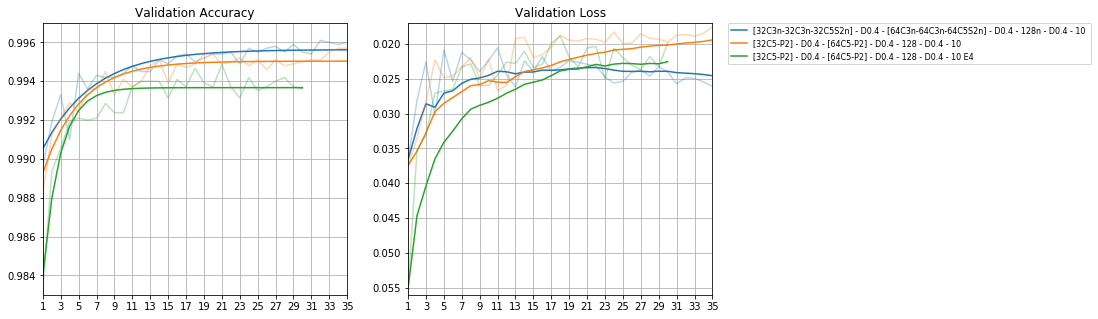

In [10]:
# Getting best model from experiment 4 for comparison
name = '[32C5-P2] - D0.4 - [64C5-P2] - D0.4 - 128 - D0.4 - 10 '
best_acc_4 = val_acc_4[name].values.tolist()
best_loss_4 = val_loss_4[name].values.tolist()

# Experiment 5 results
val_acc_5, val_loss_5 = get_results('E5')

# Appending best E4 model to new results
for i in range(len(val_acc_5) - len(val_acc_4)):
    best_acc_4.append(None)  # Must be the same size to append
    best_loss_4.append(None)
val_acc_5[name + 'E4'] = best_acc_4
val_loss_5[name + 'E4'] = best_loss_4

# Plotting results
plot_results(val_acc_5, val_loss_5)

## Discussion
### Assessing effects of the Enlarged Dataset and inducing a Learning Rate Decay
It can be clearly seen that both validation accuracy and validation loss have improved for the best model architecture chosen from experiment 4. Neural networks in general are famous for how they can improve their performance from a larger dataset alone however we can also see that validation accuracy is flattening out later as well. This is most likely due to the induced learning rate decay. We can see the effects in the stability of the validation accuracy in both models as well therefore englarging the dataset and inducing a learning decay was a good idea.

### New Advanced Model Architecture vs Old Model Architecture
Both of these models were trained using the same enlarged dataset and an induced learning rate decay however it is not so clear which model should be selected. The new advanced consistently has a better validation accuracy however its clearly not the best choice when it comes to validation loss. Not only is it showing its validation loss flattening and then dropping a little past the 14th epoch mark but also past this point the old model is doing better when validation loss is considered. We can also see how the old model's validation loss is still showing clear signs of improvement as its is still clearly showing a decreasing trend. It could be that more epochs would have made this model better. Let us let the testing set accuracy decide which of these two models is the better choice.

# 6. Testing

In [11]:
import pickle
import time

# Importing the models
names, models = [], []
for _, _, files in os.walk('data/models'):
    for file in files:
        if file.find('E5') > -1:
            path = 'data/models/' + file
            model = tf.keras.models.load_model(path)
            models.append(model)
            for name in val_acc_5.columns:
                if file.find(name) > -1:
                    names.append(name)

# Model order
print('Model order:')
for name in names:
    print(name)
print('')
                    
# Testing
timestamp = str(int(time.time()))
for name, model in dict(zip(names, models)).items():
    
    # Evaluating
    results = model.evaluate(x_test, y_test)

    # Getting predictions
    pred = model.predict(x_test)  # x_test is already scaled and reshaped
    predictions = np.argmax(pred, axis=1)
    correct = np.equal(predictions, y_test)

    # Creating dataframe
    images = [image for image in x_test]
    pred = pd.DataFrame(pred, columns=range(10))
    predictions = pd.DataFrame({'pred': predictions,  # Argmax values
                                'correct': correct,
                                'image': images})
    pred = pd.concat([pred, predictions], axis=1)

    # Saving pred dataframe
    path = f'data/test-pred {name} @{timestamp}.pkl'
    with open(path, 'wb') as f:
        pickle.dump(pred, f)

print('\nTimestamp:', timestamp)

Model order:
[32C3n-32C3n-32C5S2n] - D0.4 - [64C3n-64C3n-64C5S2n] - D0.4 - 128n - D0.4 - 10 
[32C5-P2] - D0.4 - [64C5-P2] - D0.4 - 128 - D0.4 - 10 

10000/10000 [==============================] - 1s 95us/sample - loss: 0.0130 - acc: 0.9958

Timestamp: 1569917891


## Discussion
Despite the fact that the loss is still lower the new advanced model is clearly the one we should pick. It takes 3 times longer to classify however at the end of the day accuracy is what matters.

# Conclusions
In this tutorial we learned how to:
1. Plan a hyperparameter search strategy
2. Enlarge an image dataset with image agumentation with TensorFlow and Keras
3. Induce a learning rate decay in the training process with TensorFlow and Keras